In [ ]:
# CELL 1: Load CSV and Basic Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np

# Load subject info from CSV
CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
OUTPUT_DIR = BASE_DIR / "analyses" / "rsa_corrected"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Session start mapping (for special cases)
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

# Cope mapping (condition > scramble contrasts)
COPE_MAP = {
    'face': 10, # 10, 11, 12 are the same contrasts as 1, 2, 4
    'word': 12,
    'object': 3,
    'house': 11
}

# Parcels are touchy. 
CATEGORY_PARCELS = {
    'face': ['fusiform'],
    'word': ['fusiform'], 
    'object': ['lateraloccipital'],
    'house': ['parahippocampal', 'lingual', 'isthmuscingulate']
}

print("✓ CSV loaded and configuration set")

✓ CSV loaded and configuration set


In [ ]:
# CELL 2: Streamlined Subject Loading and Configuration
def load_subjects_by_group(group_filter=None, patient_only=True):
    """Streamlined subject loading with proper configuration"""
    
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
            
        # Get available sessions
        sessions = []
        for ses_dir in subj_dir.glob('ses-*'):
            if ses_dir.is_dir():
                sessions.append(ses_dir.name.replace('ses-', ''))
        
        if not sessions:
            continue
            
        sessions = sorted(sessions, key=lambda x: int(x))
        start_session = SESSION_START.get(subject_id, 1)
        available_sessions = [s for s in sessions if int(s) >= start_session]
        
        if not available_sessions:
            continue
        
        # Proper hemisphere mapping
        if row['patient'] == 1:  # Patients
            hemisphere_full = row.get('intact_hemi', 'left')
            hemisphere = 'l' if hemisphere_full == 'left' else 'r'
        else:  # Controls 
            hemisphere = 'r'  # Default for controls (we'll add bilateral later)
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': available_sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'age_1': row['age_1'] if pd.notna(row['age_1']) else None,
            'surgery_side': row.get('SurgerySide', None) if row['patient'] == 1 else None
        }
    
    return subjects

# Load subjects systematically
ALL_PATIENTS = load_subjects_by_group(group_filter=None, patient_only=True)
OTC_PATIENTS = load_subjects_by_group(group_filter='OTC', patient_only=True)
NON_OTC_PATIENTS = load_subjects_by_group(group_filter='nonOTC', patient_only=True)
ALL_CONTROLS = load_subjects_by_group(group_filter=None, patient_only=False)

# Start with original subjects only
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

print("STREAMLINED SUBJECT LOADING COMPLETE")
print("="*50)
print(f"Patients loaded: {len(ALL_PATIENTS)}")
print(f"  - OTC: {len(OTC_PATIENTS)}")
print(f"  - nonOTC: {len(NON_OTC_PATIENTS)}")
print(f"Controls loaded: {len(ALL_CONTROLS)}")
print(f"Total analysis subjects: {len(ANALYSIS_SUBJECTS)}")

print(f"\nCORRECT CATEGORY_PARCELS:")
for category, parcels in CATEGORY_PARCELS.items():
    print(f"  {category:6s}: {parcels}")

print(f"\nSample subjects:")
for subj_id, info in list(ANALYSIS_SUBJECTS.items())[:3]:
    print(f"  {info['code']}: {info['group']} {info['patient_status']}, hemi='{info['hemi']}'")

STREAMLINED SUBJECT LOADING COMPLETE
Patients loaded: 16
  - OTC: 7
  - nonOTC: 9
Controls loaded: 9
Total analysis subjects: 25

CORRECT CATEGORY_PARCELS:
  face  : ['fusiform']
  word  : ['fusiform', 'inferiortemporal']
  object: ['lateraloccipital']
  house : ['parahippocampal', 'lingual', 'isthmuscingulate']

Sample subjects:
  OTC004: OTC patient, hemi='l'
  nonOTC007: nonOTC patient, hemi='r'
  OTC008: OTC patient, hemi='l'


In [ ]:
# CELL 3: Parcel Resampling (Both Hemispheres)
from nilearn.image import resample_to_img

def resample_parcels_to_fsl_space_streamlined(subject_id):
    """Resample ALL available parcels from FreeSurfer space to FSL space"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    code = info['code']
    first_session = info['sessions'][0]
    
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    anat_file = BASE_DIR / subject_id / f'ses-{first_session}' / 'anat' / f'{subject_id}_ses-{first_session}_T1w_brain.nii.gz'
    
    print(f"\n{code} - Resampling ALL parcels to FSL space (ses-{first_session}):")
    print("="*60)
    
    if not anat_file.exists():
        print(f"❌ FSL anatomy not found: {anat_file}")
        return
    
    if not roi_dir.exists():
        print(f"❌ ROI directory not found: {roi_dir}")
        return
    
    anat_img = nib.load(anat_file)
    print(f"Target FSL anatomy shape: {anat_img.shape}")
    
    # All parcels that might exist
    parcels = ['fusiform', 'lateraloccipital', 'parahippocampal', 'inferiortemporal', 
               'middletemporal', 'lingual', 'isthmuscingulate']
    
    total_resampled = 0
    
    # Process BOTH hemispheres where parcels exist
    for hemi in ['l', 'r']:
        hemi_name = 'left' if hemi == 'l' else 'right'
        
        # Check if any parcels exist for this hemisphere
        hemi_parcels_exist = any((roi_dir / f'{hemi}_{parcel}_mask.nii.gz').exists() 
                                for parcel in parcels)
        
        if not hemi_parcels_exist:
            print(f"  {hemi_name:>5s}: No parcels found")
            continue
        
        print(f"  {hemi_name:>5s} hemisphere:")
        hemi_resampled = 0
        
        for parcel in parcels:
            parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
            
            if parcel_file.exists():
                try:
                    parcel_img = nib.load(parcel_file)
                    original_voxels = np.sum(parcel_img.get_fdata() > 0)
                    
                    if parcel_img.shape != anat_img.shape:
                        print(f"    {parcel:20s}: {parcel_img.shape} → {anat_img.shape}")
                        
                        # Resample to FSL space
                        resampled = resample_to_img(parcel_img, anat_img, interpolation='nearest')
                        resampled_voxels = np.sum(resampled.get_fdata() > 0)
                        
                        # Overwrite with resampled version
                        nib.save(resampled, parcel_file)
                        print(f"      Voxels: {original_voxels:,} → {resampled_voxels:,}")
                        hemi_resampled += 1
                    else:
                        print(f"    {parcel:20s}: Already correct shape ✓")
                        
                except Exception as e:
                    print(f"    {parcel:20s}: Error - {e}")
        
        if hemi_resampled > 0:
            print(f"    → Resampled {hemi_resampled} {hemi_name} parcels")
        
        total_resampled += hemi_resampled
    
    print(f"✓ Total resampled: {total_resampled} parcels for {code}")

# Resample parcels for all subjects
print("\n" + "="*70)
print("STEP 1: RESAMPLING ALL PARCELS TO FSL SPACE")
print("="*70)

for subject_id in ANALYSIS_SUBJECTS.keys():
    resample_parcels_to_fsl_space_streamlined(subject_id)

print("\n✅ All available parcels aligned to FSL space!")


STEP 1: RESAMPLING ALL PARCELS TO FSL SPACE

OTC004 - Resampling ALL parcels to FSL space (ses-01):
Target FSL anatomy shape: (176, 256, 256)
   left hemisphere:
    fusiform            : Already correct shape ✓
    lateraloccipital    : Already correct shape ✓
    parahippocampal     : Already correct shape ✓
    inferiortemporal    : Already correct shape ✓
    middletemporal      : Already correct shape ✓
    lingual             : Already correct shape ✓
    isthmuscingulate    : Already correct shape ✓
  right: No parcels found
✓ Total resampled: 0 parcels for OTC004

nonOTC007 - Resampling ALL parcels to FSL space (ses-01):
Target FSL anatomy shape: (176, 256, 256)
   left: No parcels found
  right hemisphere:
    fusiform            : Already correct shape ✓
    lateraloccipital    : Already correct shape ✓
    parahippocampal     : Already correct shape ✓
    inferiortemporal    : Already correct shape ✓
    middletemporal      : Already correct shape ✓
    lingual             

In [ ]:
# CELL 4: Streamlined Bilateral Category Mask Creation
from scipy.ndimage import binary_dilation

def create_bilateral_category_masks(subject_id, dilation_iterations=1):
    """
    Create category-specific searchmasks for ALL available hemispheres
    Streamlined for bilateral processing
    """
    
    info = ANALYSIS_SUBJECTS[subject_id]
    code = info['code']
    first_session = info['sessions'][0]
    
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    
    print(f"\n{'='*70}")
    print(f"{code} - Bilateral Category Masks [ses-{first_session}] [{info['group']} {info['patient_status']}]")
    print(f"{'='*70}")
    
    if not roi_dir.exists():
        print(f"❌ ROI directory not found: {roi_dir}")
        return {}
    
    category_masks = {}
    
    # Process BOTH hemispheres where parcels exist
    for hemi in ['l', 'r']:
        hemi_name = 'left' if hemi == 'l' else 'right'
        
        # Check if any parcels exist for this hemisphere
        hemi_has_parcels = False
        for category, parcel_list in CATEGORY_PARCELS.items():
            for parcel in parcel_list:
                if (roi_dir / f'{hemi}_{parcel}_mask.nii.gz').exists():
                    hemi_has_parcels = True
                    break
            if hemi_has_parcels:
                break
        
        if not hemi_has_parcels:
            print(f"\n{hemi_name.upper()} hemisphere: No parcels found")
            continue
        
        print(f"\n{hemi_name.upper()} hemisphere:")
        hemi_masks_created = 0
        
        for category, parcel_list in CATEGORY_PARCELS.items():
            print(f"  {category.upper()}:")
            
            combined = None
            ref_img = None
            
            # Combine parcels for this category
            for parcel in parcel_list:
                parcel_file = roi_dir / f'{hemi}_{parcel}_mask.nii.gz'
                
                if not parcel_file.exists():
                    print(f"    ⚠️  Missing: {parcel}")
                    continue
                
                try:
                    img = nib.load(parcel_file)
                    mask = img.get_fdata() > 0
                    n_vox = np.sum(mask)
                    print(f"    {parcel:20s}: {n_vox:6d} voxels")
                    
                    if combined is None:
                        combined = mask
                        ref_img = img
                    else:
                        combined = combined | mask
                        
                except Exception as e:
                    print(f"    {parcel:20s}: Error loading - {e}")
                    continue
            
            if combined is None:
                print(f"    ❌ No valid parcels found")
                continue
            
            print(f"    Combined (before dilation): {np.sum(combined):6d} voxels")
            
            # Apply dilation
            combined = binary_dilation(combined, iterations=dilation_iterations)
            print(f"    After 1x dilation:          {np.sum(combined):6d} voxels")
            
            # Save searchmask
            output_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            mask_img = nib.Nifti1Image(combined.astype(np.float32), ref_img.affine)
            nib.save(mask_img, output_file)
            
            # Store in results
            mask_key = f'{hemi}_{category}'
            category_masks[mask_key] = output_file
            
            print(f"    ✓ Saved: {output_file.name}")
            hemi_masks_created += 1
        
        print(f"  → Created {hemi_masks_created}/4 {hemi_name} hemisphere masks")
    
    return category_masks

# Create bilateral category masks systematically
print("\n" + "="*70)
print("STEP 2: CREATING BILATERAL CATEGORY MASKS")
print("="*70)

all_category_masks = {}
total_masks_created = 0

for subject_id in ANALYSIS_SUBJECTS.keys():
    subject_masks = create_bilateral_category_masks(subject_id, dilation_iterations=1)
    all_category_masks[subject_id] = subject_masks
    total_masks_created += len(subject_masks)

print(f"\n✅ Bilateral category mask creation complete!")
print(f"Total searchmasks created: {total_masks_created}")


STEP 2: CREATING BILATERAL CATEGORY MASKS

OTC004 - Bilateral Category Masks [ses-01] [OTC patient]

LEFT hemisphere:
  FACE:
    fusiform            :  12134 voxels
    Combined (before dilation):  12134 voxels
    After 1x dilation:           19331 voxels
    ✓ Saved: l_face_searchmask.nii.gz
  WORD:
    fusiform            :  12134 voxels
    inferiortemporal    :  14609 voxels
    Combined (before dilation):  26743 voxels
    After 1x dilation:           40129 voxels
    ✓ Saved: l_word_searchmask.nii.gz
  OBJECT:
    lateraloccipital    :  15770 voxels
    Combined (before dilation):  15770 voxels
    After 1x dilation:           25843 voxels
    ✓ Saved: l_object_searchmask.nii.gz
  HOUSE:
    parahippocampal     :   1847 voxels
    lingual             :   9576 voxels
    isthmuscingulate    :   3317 voxels
    Combined (before dilation):  14740 voxels
    After 1x dilation:           24507 voxels
    ✓ Saved: l_house_searchmask.nii.gz
  → Created 4/4 left hemisphere masks

RIGH

BILATERAL MASK VERIFICATION - SAMPLE SUBJECTS
Checking sample subjects: 3

📊 VERIFYING: OTC004 (OTC patient)
--------------------------------------------------
   left hemisphere: 4/4 categories
  right hemisphere: 0/4 categories
  → Left hemisphere only available

📊 VERIFYING: nonOTC007 (nonOTC patient)
--------------------------------------------------
   left hemisphere: 0/4 categories
  right hemisphere: 4/4 categories
  → Right hemisphere only available

📊 VERIFYING: control018 (control control)
--------------------------------------------------
   left hemisphere: 4/4 categories
  right hemisphere: 4/4 categories
    ✅ face: L=-28.3, R= 33.3
    ✅ house: L= -9.4, R= 14.8


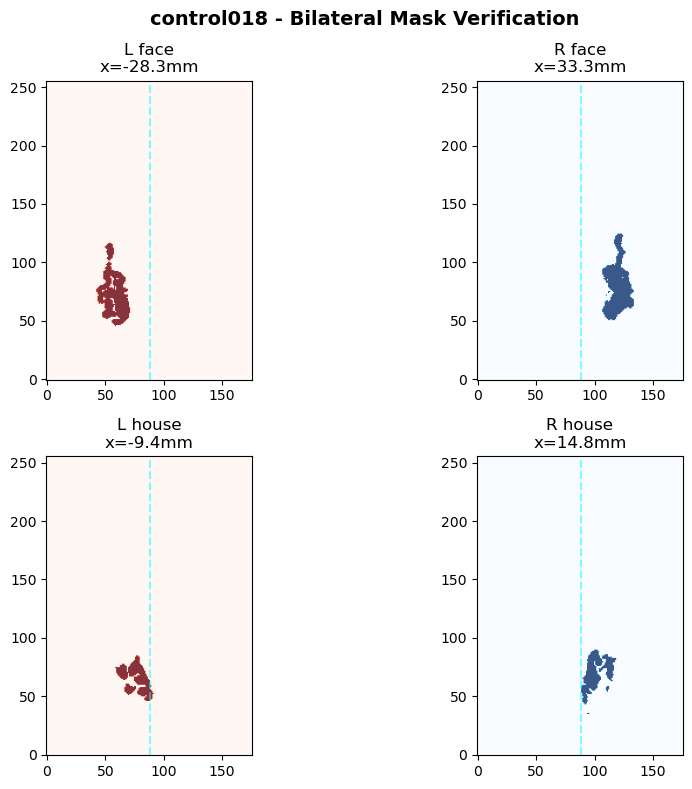


📊 BILATERAL MASK CREATION SUMMARY
Bilateral controls: 9
Patients with bilateral data: 0
Total searchmasks created: 132

✅ BILATERAL MASK VERIFICATION COMPLETE!
Ready to proceed with expanded dataset creation


In [15]:
# CELL 4-Verify: Quick Visual Verification of Bilateral Masks
from nilearn import plotting, image
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass

def verify_bilateral_masks_sample():
    """Quick verification of bilateral mask creation with sample subjects"""
    
    print("BILATERAL MASK VERIFICATION - SAMPLE SUBJECTS")
    print("="*60)
    
    # Select representative subjects from each group
    sample_subjects = []
    
    # Get one from each group if available
    for group_type in ['OTC', 'nonOTC', 'control']:
        group_subjects = [sid for sid, info in ANALYSIS_SUBJECTS.items() 
                         if ((info['group'] == group_type) if group_type != 'control' 
                             else (info['patient_status'] == 'control'))]
        
        if group_subjects:
            # Pick first available subject from each group
            sample_subjects.append(group_subjects[0])
    
    print(f"Checking sample subjects: {len(sample_subjects)}")
    
    for subject_id in sample_subjects:
        verify_single_subject_bilateral(subject_id)

def verify_single_subject_bilateral(subject_id):
    """Verify bilateral masks for a single subject"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    code = info['code']
    first_session = info['sessions'][0]
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    
    print(f"\n📊 VERIFYING: {code} ({info['group']} {info['patient_status']})")
    print("-" * 50)
    
    # Check what hemispheres we have
    hemispheres_available = {}
    for hemi in ['l', 'r']:
        hemi_masks = sum(1 for cat in ['face', 'word', 'object', 'house'] 
                        if (roi_dir / f'{hemi}_{cat}_searchmask.nii.gz').exists())
        hemispheres_available[hemi] = hemi_masks
        
        hemi_name = 'left' if hemi == 'l' else 'right'
        print(f"  {hemi_name:>5s} hemisphere: {hemi_masks}/4 categories")
    
    # If we have bilateral data, create visualization
    if hemispheres_available['l'] >= 2 and hemispheres_available['r'] >= 2:
        create_bilateral_comparison_plot(subject_id, info)
    elif hemispheres_available['l'] >= 2:
        print(f"  → Left hemisphere only available")
    elif hemispheres_available['r'] >= 2:
        print(f"  → Right hemisphere only available")
    else:
        print(f"  → Insufficient mask data")

def create_bilateral_comparison_plot(subject_id, info):
    """Create a quick bilateral comparison plot"""
    
    code = info['code']
    first_session = info['sessions'][0]
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    
    # Just show face and house as examples
    categories_to_show = ['face', 'house']
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'{code} - Bilateral Mask Verification', fontsize=14, fontweight='bold')
    
    for cat_idx, category in enumerate(categories_to_show):
        
        # Load bilateral masks
        l_mask_file = roi_dir / f'l_{category}_searchmask.nii.gz'
        r_mask_file = roi_dir / f'r_{category}_searchmask.nii.gz'
        
        if l_mask_file.exists() and r_mask_file.exists():
            try:
                l_mask_data = nib.load(l_mask_file).get_fdata()
                r_mask_data = nib.load(r_mask_file).get_fdata()
                
                # Get centers for slicing
                l_com = center_of_mass(l_mask_data > 0)
                r_com = center_of_mass(r_mask_data > 0)
                
                # Get world coordinates  
                l_com_world = nib.affines.apply_affine(nib.load(l_mask_file).affine, l_com)
                r_com_world = nib.affines.apply_affine(nib.load(r_mask_file).affine, r_com)
                
                # Use axial slice
                slice_z = int(max(l_com[2], r_com[2]))
                
                # Left hemisphere
                ax_l = axes[cat_idx, 0]
                ax_l.imshow(l_mask_data[:, :, slice_z].T, origin='lower', cmap='Reds', alpha=0.8)
                ax_l.axvline(x=l_mask_data.shape[0]//2, color='cyan', linestyle='--', alpha=0.5)
                ax_l.set_title(f'L {category}\nx={l_com_world[0]:.1f}mm')
                
                # Right hemisphere  
                ax_r = axes[cat_idx, 1]
                ax_r.imshow(r_mask_data[:, :, slice_z].T, origin='lower', cmap='Blues', alpha=0.8)
                ax_r.axvline(x=r_mask_data.shape[0]//2, color='cyan', linestyle='--', alpha=0.5)
                ax_r.set_title(f'R {category}\nx={r_com_world[0]:.1f}mm')
                
                # Check positioning
                l_correct = l_com_world[0] < -5
                r_correct = r_com_world[0] > 5
                status = "✅" if (l_correct and r_correct) else "⚠️"
                
                print(f"    {status} {category}: L={l_com_world[0]:5.1f}, R={r_com_world[0]:5.1f}")
                
            except Exception as e:
                print(f"    ❌ {category}: Visualization error - {e}")
        
        else:
            print(f"    ⚠️ {category}: Missing bilateral masks")
    
    plt.tight_layout()
    plt.show()

def summary_mask_statistics():
    """Quick summary of mask creation results"""
    
    print(f"\n📊 BILATERAL MASK CREATION SUMMARY")
    print("="*50)
    
    stats = {'bilateral_controls': 0, 'patients_with_bilateral': 0, 'total_masks': 0}
    
    for subject_id, info in ANALYSIS_SUBJECTS.items():
        first_session = info['sessions'][0]
        roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
        
        # Count masks
        l_masks = sum(1 for cat in ['face', 'word', 'object', 'house'] 
                     if (roi_dir / f'l_{cat}_searchmask.nii.gz').exists())
        r_masks = sum(1 for cat in ['face', 'word', 'object', 'house'] 
                     if (roi_dir / f'r_{cat}_searchmask.nii.gz').exists())
        
        stats['total_masks'] += l_masks + r_masks
        
        if l_masks >= 3 and r_masks >= 3:
            if info['patient_status'] == 'control':
                stats['bilateral_controls'] += 1
            else:
                stats['patients_with_bilateral'] += 1
    
    print(f"Bilateral controls: {stats['bilateral_controls']}")
    print(f"Patients with bilateral data: {stats['patients_with_bilateral']}")
    print(f"Total searchmasks created: {stats['total_masks']}")
    
    return stats

# Run verification
verify_bilateral_masks_sample()

# Get summary statistics
mask_stats = summary_mask_statistics()

print(f"\n✅ BILATERAL MASK VERIFICATION COMPLETE!")
print(f"Ready to proceed with expanded dataset creation")

In [ ]:
# CELL 5: Streamlined Bilateral Functional ROI Extraction
from scipy.ndimage import label, center_of_mass

def extract_functional_rois_bilateral(subject_id, threshold_z=2.3):
    """
    Extract functional ROIs from ALL available hemispheres
    Streamlined for bilateral processing
    """
    
    info = ANALYSIS_SUBJECTS[subject_id]
    code = info['code']
    sessions = info['sessions']
    first_session = sessions[0]
    
    print(f"\n{'='*70}")
    print(f"{code} - Bilateral Functional Extraction [ses-{first_session}, z>{threshold_z}] [{info['group']} {info['patient_status']}]")
    print(f"{'='*70}")
    
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    
    if not roi_dir.exists():
        print(f"❌ ROI directory not found: {roi_dir}")
        return {}
    
    all_results = {}
    
    # Check which hemispheres have masks available
    available_hemispheres = {}
    for hemi in ['l', 'r']:
        hemi_mask_count = sum(1 for cat in CATEGORY_PARCELS.keys() 
                             if (roi_dir / f'{hemi}_{cat}_searchmask.nii.gz').exists())
        if hemi_mask_count > 0:
            available_hemispheres[hemi] = hemi_mask_count
    
    if not available_hemispheres:
        print(f"❌ No searchmasks found for any hemisphere")
        return {}
    
    print(f"Available hemispheres: {dict(available_hemispheres)}")
    
    # Process each available hemisphere
    for hemi, mask_count in available_hemispheres.items():
        hemi_name = 'left' if hemi == 'l' else 'right'
        print(f"\n{hemi_name.upper()} HEMISPHERE ({mask_count}/4 masks):")
        
        # Process each category
        for category, cope_num in COPE_MAP.items():
            print(f"  {category.upper()}:")
            
            # Load mask for this hemisphere/category
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            
            if not mask_file.exists():
                print(f"    ⚠️  Mask not found")
                continue
            
            try:
                mask = nib.load(mask_file).get_fdata() > 0
                affine = nib.load(mask_file).affine
            except Exception as e:
                print(f"    ❌ Corrupted mask: {e}")
                continue
            
            # Store results for this hemisphere/category combination
            hemi_category_key = f'{hemi}_{category}'
            all_results[hemi_category_key] = {}
            
            # Process each session
            for session in sessions:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                # Select correct zstat file
                zstat_file = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / zstat_file
                
                if not cope_file.exists():
                    print(f"    ses-{session}: cope file missing")
                    continue
                
                try:
                    # Load functional activation
                    zstat = nib.load(cope_file).get_fdata()
                    
                    # Apply threshold and mask
                    suprathresh = (zstat > threshold_z) & mask
                    
                    if suprathresh.sum() < 50:
                        print(f"    ses-{session}: <50 voxels")
                        continue
                    
                    # Find connected components
                    labeled, n_clusters = label(suprathresh)
                    if n_clusters == 0:
                        print(f"    ses-{session}: No clusters")
                        continue
                    
                    # Get largest cluster
                    cluster_sizes = [(labeled == i).sum() for i in range(1, n_clusters + 1)]
                    largest_idx = np.argmax(cluster_sizes) + 1
                    roi_mask = (labeled == largest_idx)
                    
                    # Extract metrics
                    peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
                    peak_z = zstat[peak_idx]
                    centroid = nib.affines.apply_affine(affine, center_of_mass(roi_mask))
                    
                    # Store results
                    all_results[hemi_category_key][session] = {
                        'n_voxels': cluster_sizes[largest_idx - 1],
                        'peak_z': peak_z,
                        'centroid': centroid,
                        'roi_mask': roi_mask,
                        'hemisphere': hemi
                    }
                    
                    print(f"    ses-{session}: {cluster_sizes[largest_idx - 1]:4d} voxels, z={peak_z:.2f}")
                    
                except Exception as e:
                    print(f"    ses-{session}: Error - {e}")
                    continue
    
    return all_results

# Extract functional ROIs for all subjects with bilateral processing
print("\n" + "="*70)
print("STREAMLINED BILATERAL FUNCTIONAL ROI EXTRACTION")
print("="*70)

golarai_functional_final = {}
successful_extractions = 0
failed_extractions = []

for subject_id in ANALYSIS_SUBJECTS.keys():
    try:
        results = extract_functional_rois_bilateral(subject_id, threshold_z=2.3)
        if results:  # Only store if we got some results
            golarai_functional_final[subject_id] = results
            successful_extractions += 1
        else:
            failed_extractions.append(f"{ANALYSIS_SUBJECTS[subject_id]['code']} (no ROIs)")
    except Exception as e:
        failed_extractions.append(f"{ANALYSIS_SUBJECTS[subject_id]['code']} ({e})")

print(f"\n✓ BILATERAL FUNCTIONAL EXTRACTION COMPLETE!")
print(f"Successful extractions: {successful_extractions}")
if failed_extractions:
    print(f"Failed extractions: {failed_extractions}")

# Quick summary of bilateral data
bilateral_entries = 0
for subject_id, results in golarai_functional_final.items():
    left_categories = [k for k in results.keys() if k.startswith('l_')]
    right_categories = [k for k in results.keys() if k.startswith('r_')]
    
    if left_categories and right_categories:
        bilateral_entries += 1

print(f"Subjects with bilateral functional data: {bilateral_entries}")


STREAMLINED BILATERAL FUNCTIONAL ROI EXTRACTION

OTC004 - Bilateral Functional Extraction [ses-01, z>2.3] [OTC patient]
Available hemispheres: {'l': 4}

LEFT HEMISPHERE (4/4 masks):
  FACE:
    ses-01:  352 voxels, z=3.50
    ses-02: 2834 voxels, z=6.81
    ses-03: 4282 voxels, z=8.76
    ses-05: 3798 voxels, z=8.69
    ses-06: 4068 voxels, z=13.33
    ses-07: cope file missing
  WORD:
    ses-01:   28 voxels, z=2.67
    ses-02: 1369 voxels, z=4.49
    ses-03: 3111 voxels, z=6.24
    ses-05: 1153 voxels, z=5.49
    ses-06: 1255 voxels, z=4.48
    ses-07: cope file missing
  OBJECT:
    ses-01: 3747 voxels, z=6.77
    ses-02: 6577 voxels, z=7.90
    ses-03: 8011 voxels, z=8.62
    ses-05: 10690 voxels, z=10.12
    ses-06: 7137 voxels, z=11.29
    ses-07: cope file missing
  HOUSE:
    ses-01: 1379 voxels, z=5.25
    ses-02: 1998 voxels, z=9.42
    ses-03: 3109 voxels, z=11.75
    ses-05: 4933 voxels, z=12.23
    ses-06: 4691 voxels, z=12.64
    ses-07: cope file missing

nonOTC007 - Bi

In [ ]:
# CELL 6: Updated Bilateral Analysis Summary
def summarize_bilateral_analysis_results(functional_results, subjects_dict):
    """
    Create summary of bilateral analysis results
    Updated for new hemisphere_category structure
    """
    
    print("\n" + "="*70)
    print("BILATERAL ANALYSIS SUMMARY")
    print("="*70)
    
    # Group subjects by type
    groups = {}
    for subject_id, info in subjects_dict.items():
        group_key = f"{info['group']}_{info['patient_status']}"
        if group_key not in groups:
            groups[group_key] = []
        groups[group_key].append(subject_id)
    
    # Summary by hemisphere_category
    all_hemi_categories = set()
    for subject_results in functional_results.values():
        all_hemi_categories.update(subject_results.keys())
    
    for hemi_cat in sorted(all_hemi_categories):
        hemi, category = hemi_cat.split('_', 1) if '_' in hemi_cat else ('?', hemi_cat)
        hemi_name = 'LEFT' if hemi == 'l' else 'RIGHT' if hemi == 'r' else 'UNKNOWN'
        
        print(f"\n{hemi_name} {category.upper()}:")
        print("-" * 50)
        
        for group_key, subject_list in groups.items():
            session_data = {}
            
            for subject_id in subject_list:
                if subject_id in functional_results and hemi_cat in functional_results[subject_id]:
                    for session, data in functional_results[subject_id][hemi_cat].items():
                        if session not in session_data:
                            session_data[session] = []
                        session_data[session].append(data['n_voxels'])
            
            if session_data:
                print(f"  {group_key}:")
                for session in sorted(session_data.keys()):
                    voxels = session_data[session]
                    mean_voxels = np.mean(voxels)
                    print(f"    ses-{session}: {len(voxels)} subjects, mean={mean_voxels:.1f} voxels")
    
    # Subject completion rates
    print(f"\n{'='*70}")
    print("BILATERAL COMPLETION RATES")
    print(f"{'='*70}")
    
    for subject_id, info in subjects_dict.items():
        code = info['code']
        group_status = f"{info['group']} {info['patient_status']}"
        
        if subject_id in functional_results:
            results = functional_results[subject_id]
            
            # Count by hemisphere
            left_categories = [k for k in results.keys() if k.startswith('l_')]
            right_categories = [k for k in results.keys() if k.startswith('r_')]
            
            total_entries = len(results)
            bilateral_status = ""
            
            if left_categories and right_categories:
                bilateral_status = f"BILATERAL (L:{len(left_categories)}, R:{len(right_categories)})"
            elif left_categories:
                bilateral_status = f"LEFT ONLY ({len(left_categories)})"
            elif right_categories:
                bilateral_status = f"RIGHT ONLY ({len(right_categories)})"
            
            print(f"{code:10s} ({group_status:15s}): {total_entries} total entries - {bilateral_status}")
        else:
            print(f"{code:10s} ({group_status:15s}): No functional data")

# Generate summary for bilateral analysis
summarize_bilateral_analysis_results(golarai_functional_final, ANALYSIS_SUBJECTS)

print(f"\n✓ Bilateral analysis complete!")
print(f"✓ Data structure: subject -> hemisphere_category -> session")
print(f"✓ Results saved to: {OUTPUT_DIR}")


BILATERAL ANALYSIS SUMMARY

LEFT FACE:
--------------------------------------------------
  OTC_patient:
    ses-01: 2 subjects, mean=4454.5 voxels
    ses-02: 2 subjects, mean=4815.5 voxels
    ses-03: 1 subjects, mean=4282.0 voxels
    ses-05: 1 subjects, mean=3798.0 voxels
    ses-06: 1 subjects, mean=4068.0 voxels
  nonOTC_patient:
    ses-01: 5 subjects, mean=4604.8 voxels
    ses-02: 5 subjects, mean=4534.0 voxels
  control_control:
    ses-01: 7 subjects, mean=3831.4 voxels
    ses-02: 9 subjects, mean=3925.1 voxels
    ses-03: 2 subjects, mean=3017.5 voxels

LEFT HOUSE:
--------------------------------------------------
  OTC_patient:
    ses-01: 2 subjects, mean=3400.5 voxels
    ses-02: 2 subjects, mean=1788.5 voxels
    ses-03: 1 subjects, mean=3109.0 voxels
    ses-05: 1 subjects, mean=4933.0 voxels
    ses-06: 1 subjects, mean=4691.0 voxels
  nonOTC_patient:
    ses-01: 5 subjects, mean=4956.0 voxels
    ses-02: 5 subjects, mean=3050.6 voxels
  control_control:
    ses-01

In [ ]:
# CELL 7: Updated Bilateral Peak Drift Calculation
def calculate_bilateral_peak_drift(functional_results, subjects_dict):
    """Calculate peak drift for bilateral data structure"""
    print("\nBilateral Peak Movement Summary:")
    print(f"{'Subject':<10} {'Hemi_Category':<12} {'Drift (mm)':<12} {'Sessions':<15} {'Group'}")
    print("-"*85)
    
    for subj in subjects_dict.keys():
        info = subjects_dict[subj]
        code = info['code']
        
        if subj not in functional_results:
            continue
        
        # Process all hemisphere_category combinations
        for hemi_cat in functional_results[subj].keys():
            sessions = sorted(functional_results[subj][hemi_cat].keys())
            if len(sessions) < 2:
                continue
            
            first = functional_results[subj][hemi_cat][sessions[0]]['centroid']
            last = functional_results[subj][hemi_cat][sessions[-1]]['centroid']
            drift = np.linalg.norm(np.array(last) - np.array(first))
            
            group_status = f"{info['group']}/{info['patient_status']}"
            session_range = f"{sessions[0]}-{sessions[-1]}"
            
            print(f"{code:<10} {hemi_cat:<12} {drift:>8.1f}     {session_range:<15} {group_status}")

calculate_bilateral_peak_drift(golarai_functional_final, ANALYSIS_SUBJECTS)


Bilateral Peak Movement Summary:
Subject    Hemi_Category Drift (mm)   Sessions        Group
-------------------------------------------------------------------------------------
OTC004     l_face           11.1     01-06           OTC/patient
OTC004     l_word            7.9     01-06           OTC/patient
OTC004     l_object          3.2     01-06           OTC/patient
OTC004     l_house          14.5     01-06           OTC/patient
nonOTC007  r_face            3.6     01-04           nonOTC/patient
nonOTC007  r_word           28.3     01-04           nonOTC/patient
nonOTC007  r_object          3.7     01-04           nonOTC/patient
nonOTC007  r_house           9.6     01-04           nonOTC/patient
OTC008     l_face            6.6     01-02           OTC/patient
OTC008     l_word           18.5     01-02           OTC/patient
OTC008     l_object         11.0     01-02           OTC/patient
OTC008     l_house           6.4     01-02           OTC/patient
OTC010     r_face           

In [ ]:
# CELL 8: Updated Bilateral Peak Summary Table
import pandas as pd

def create_bilateral_peak_summary_table(functional_results, subjects_dict):
    """Create comprehensive table for bilateral data structure"""
    
    rows = []
    
    for subject_id, info in subjects_dict.items():
        if subject_id not in functional_results:
            continue
        
        code = info['code']
        group = info['group']
        patient_status = info['patient_status']
        
        # Process all hemisphere_category combinations
        for hemi_cat, session_data in functional_results[subject_id].items():
            # Parse hemisphere and category
            if '_' in hemi_cat:
                hemi, category = hemi_cat.split('_', 1)
                hemi_name = 'left' if hemi == 'l' else 'right'
            else:
                hemi = 'unknown'
                category = hemi_cat
                hemi_name = 'unknown'
            
            sessions = list(session_data.keys())
            n_sessions = len(sessions)
            
            # Calculate drift if multiple sessions
            if n_sessions > 1:
                first_peak = session_data[sessions[0]]['centroid']
                last_peak = session_data[sessions[-1]]['centroid']
                drift = np.linalg.norm(np.array(last_peak) - np.array(first_peak))
            else:
                drift = 0
            
            # Add row for each session
            for session in sessions:
                data = session_data[session]
                rows.append({
                    'Subject': code,
                    'Group': group,
                    'Status': patient_status,
                    'Hemisphere': hemi_name,
                    'Category': category,
                    'Hemi_Category': hemi_cat,
                    'Session': session,
                    'X': data['centroid'][0],
                    'Y': data['centroid'][1], 
                    'Z': data['centroid'][2],
                    'N_Voxels': data['n_voxels'],
                    'Peak_Z': data['peak_z'],
                    'Total_Drift': drift if session == sessions[-1] else None
                })
    
    return pd.DataFrame(rows)

# Create comprehensive bilateral summary
print("\n" + "="*70)
print("BILATERAL FUNCTIONAL PEAK SUMMARY")
print("="*70)

bilateral_peak_summary = create_bilateral_peak_summary_table(golarai_functional_final, ANALYSIS_SUBJECTS)

# Display by group and hemisphere
for group in bilateral_peak_summary['Group'].unique():
    print(f"\n{group.upper()} GROUP:")
    print("-" * 50)
    
    group_data = bilateral_peak_summary[bilateral_peak_summary['Group'] == group]
    
    # Show by hemisphere
    for hemi in ['left', 'right']:
        hemi_data = group_data[group_data['Hemisphere'] == hemi]
        if len(hemi_data) > 0:
            print(f"  {hemi.upper()} hemisphere:")
            
            for category in ['face', 'word', 'object', 'house']:
                cat_data = hemi_data[hemi_data['Category'] == category]
                if len(cat_data) > 0:
                    n_subjects = cat_data['Subject'].nunique()
                    total_sessions = len(cat_data)
                    avg_voxels = cat_data['N_Voxels'].mean()
                    print(f"    {category:8s}: {n_subjects:2d} subjects, {total_sessions:2d} sessions, avg {avg_voxels:5.0f} voxels")

# Save full table
output_file = OUTPUT_DIR / 'bilateral_functional_peaks_summary.csv'
bilateral_peak_summary.to_csv(output_file, index=False)
print(f"\n✓ Full bilateral table saved to: {output_file}")

# Enhanced drift analysis
print("\n" + "="*70)
print("BILATERAL DRIFT ANALYSIS (multi-session subjects)")
print("="*70)

drift_data = bilateral_peak_summary[bilateral_peak_summary['Total_Drift'].notna()]
if len(drift_data) > 0:
    print(f"{'Subject':<10} {'Hemisphere':<10} {'Category':<8} {'Drift (mm)':<12} {'Sessions':<10} {'Group'}")
    print("-" * 75)
    for _, row in drift_data.iterrows():
        sessions = bilateral_peak_summary[
            (bilateral_peak_summary['Subject'] == row['Subject']) & 
            (bilateral_peak_summary['Hemi_Category'] == row['Hemi_Category'])
        ]['Session'].tolist()
        session_str = f"{sessions[0]}-{sessions[-1]}"
        print(f"{row['Subject']:<10} {row['Hemisphere']:<10} {row['Category']:<8} {row['Total_Drift']:>8.1f}        {session_str:<10} {row['Group']}")
else:
    print("No multi-session data found")

print(f"\n✓ Bilateral analysis complete!")
print(f"✓ Hemisphere_category structure successfully processed")


BILATERAL FUNCTIONAL PEAK SUMMARY

OTC GROUP:
--------------------------------------------------
  LEFT hemisphere:
    face    :  2 subjects,  7 sessions, avg  4384 voxels
    word    :  2 subjects,  7 sessions, avg   878 voxels
    object  :  2 subjects,  7 sessions, avg  6454 voxels
    house   :  2 subjects,  7 sessions, avg  3302 voxels
  RIGHT hemisphere:
    face    :  4 subjects, 10 sessions, avg  3001 voxels
    word    :  4 subjects, 10 sessions, avg  1118 voxels
    object  :  4 subjects, 10 sessions, avg  8216 voxels
    house   :  4 subjects, 10 sessions, avg  1598 voxels

NONOTC GROUP:
--------------------------------------------------
  LEFT hemisphere:
    face    :  5 subjects, 10 sessions, avg  4569 voxels
    word    :  5 subjects, 10 sessions, avg  6613 voxels
    object  :  5 subjects, 10 sessions, avg  8032 voxels
    house   :  5 subjects, 10 sessions, avg  4003 voxels
  RIGHT hemisphere:
    face    :  4 subjects, 10 sessions, avg  3972 voxels
    word    :  4 

In [18]:
# CELL 9: Bilateral Data Coverage Check
def check_bilateral_mask_coverage():
    """Check what searchmasks exist for each subject and hemisphere"""
    
    print("BILATERAL SEARCHMASK COVERAGE CHECK")
    print("="*70)
    
    coverage_data = []
    categories = ['face', 'word', 'object', 'house']
    hemispheres = ['l', 'r']
    
    print(f"{'Subject':<12} {'Group':<8} {'Status':<8} {'L_Face':<7} {'L_Word':<7} {'L_Obj':<6} {'L_House':<8} {'R_Face':<7} {'R_Word':<7} {'R_Obj':<6} {'R_House'}")
    print("-" * 90)
    
    for subject_id, info in ANALYSIS_SUBJECTS.items():
        code = info['code']
        group = info['group']
        status = info['patient_status']
        first_session = info['sessions'][0]
        
        roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
        
        row_data = {
            'Subject': code,
            'Group': group,
            'Status': status,
            'Assigned_Hemi': info['hemi']
        }
        
        # Check each hemisphere × category combination
        display_row = f"{code:<12} {group:<8} {status:<8}"
        
        for hemi in hemispheres:
            hemi_count = 0
            for category in categories:
                mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
                exists = mask_file.exists()
                
                # Store in data
                row_data[f'{hemi}_{category}'] = exists
                
                # Add to display
                status_symbol = "✓" if exists else "✗"
                if category == 'face':
                    display_row += f" {status_symbol:>6s}"
                elif category == 'object':
                    display_row += f" {status_symbol:>5s}"
                elif category == 'house':
                    display_row += f" {status_symbol:>7s}"
                else:
                    display_row += f" {status_symbol:>6s}"
                
                if exists:
                    hemi_count += 1
            
            row_data[f'{hemi}_total'] = hemi_count
        
        coverage_data.append(row_data)
        print(display_row)
    
    # Summary statistics
    print(f"\n{'='*70}")
    print("COVERAGE SUMMARY")
    print(f"{'='*70}")
    
    total_subjects = len(coverage_data)
    
    for hemi in hemispheres:
        hemi_name = "LEFT" if hemi == 'l' else "RIGHT"
        print(f"\n{hemi_name} HEMISPHERE:")
        print("-" * 20)
        
        for category in categories:
            count = sum(1 for row in coverage_data if row[f'{hemi}_{category}'])
            percentage = (count/total_subjects) * 100
            print(f"  {category:8s}: {count:2d}/{total_subjects:2d} subjects ({percentage:5.1f}%)")
        
        # Complete hemisphere coverage
        complete_count = sum(1 for row in coverage_data if row[f'{hemi}_total'] == 4)
        complete_percentage = (complete_count/total_subjects) * 100
        print(f"  Complete : {complete_count:2d}/{total_subjects:2d} subjects ({complete_percentage:5.1f}%)")
    
    # Group breakdown
    print(f"\nGROUP BREAKDOWN:")
    print("-" * 20)
    
    for group in ['OTC', 'nonOTC', 'control']:
        group_data = [row for row in coverage_data if row['Group'] == group]
        if len(group_data) == 0:
            continue
            
        print(f"\n{group} ({len(group_data)} subjects):")
        
        for hemi in hemispheres:
            hemi_name = "L" if hemi == 'l' else "R"
            complete_count = sum(1 for row in group_data if row[f'{hemi}_total'] == 4)
            print(f"  {hemi_name} complete: {complete_count}/{len(group_data)}")
    
    return coverage_data

# Run coverage check
coverage_results = check_bilateral_mask_coverage()

print(f"\n✓ Coverage check complete!")
print(f"📊 Ready to proceed with bilateral analysis planning")

BILATERAL SEARCHMASK COVERAGE CHECK
Subject      Group    Status   L_Face  L_Word  L_Obj  L_House  R_Face  R_Word  R_Obj  R_House
------------------------------------------------------------------------------------------
OTC004       OTC      patient       ✓      ✓     ✓       ✓      ✗      ✗     ✗       ✗
nonOTC007    nonOTC   patient       ✗      ✗     ✗       ✗      ✓      ✓     ✓       ✓
OTC008       OTC      patient       ✓      ✓     ✓       ✓      ✗      ✗     ✗       ✗
OTC010       OTC      patient       ✗      ✗     ✗       ✗      ✓      ✓     ✓       ✓
OTC017       OTC      patient       ✗      ✗     ✗       ✗      ✓      ✓     ✓       ✓
OTC021       OTC      patient       ✗      ✗     ✗       ✗      ✓      ✓     ✓       ✓
nonOTC045    nonOTC   patient       ✗      ✗     ✗       ✗      ✓      ✓     ✓       ✓
nonOTC047    nonOTC   patient       ✓      ✓     ✓       ✓      ✗      ✗     ✗       ✗
nonOTC049    nonOTC   patient       ✓      ✓     ✓       ✓      ✗      ✗     ✗     